In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from scipy import stats

In [2]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = np.round(mean_absolute_error(y_pred_test,y_test),5)
    result['mse'] = np.round(mean_squared_error(y_pred_test,y_test),5)
    result['R2'] = np.round(r2_score(y_train,y_pred_train),5)
    result['name'] = name
    result['feature_size'] = X_train.shape[1]
    result['train_size'] = X_train.shape[0]
    result['test_size'] = X_test.shape[0]

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name,  rf_param, xgb_param, svr_param, verbose = 0,):

    error_report = []
    model_dict = {}


    # remove 0 rating
    df_input = df_input[df_input['rating']>0]

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    


    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report


def bulk_train_k_fold(df_input, drop_column, target_column, dataset_name, rf_param, xgb_param, svr_param, verbose = 0):

        
    # remove 0 rating
    df_input = df_input[df_input['rating'] > 0]

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)

    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    # cross validation 
    scoring = ['neg_mean_absolute_error','neg_mean_squared_error','r2']

    if rf_param:
        regr = RandomForestRegressor(**rf_param)
    else :
        regr = RandomForestRegressor(random_state=0)
        
    result_rf = cross_validation(regr, X_train, y_train, scoring = scoring, cv =5 )
    df_rf = pd.DataFrame(result_rf)
    df_rf['name'] = 'rf'

    if xgb_param:
        xgbr = XGBRegressor(**xgb_param)
    else :
        xgbr = XGBRegressor(random_state=0)

    result_xgb = cross_validation(xgbr, X_train, y_train, scoring = scoring, cv =5 )
    df_xgb = pd.DataFrame(result_xgb)
    df_xgb['name'] = 'xgb'


    if svr_param:
        svr = SVR(**svr_param)
    else :
        svr = SVR(kernel='poly')

    result_svr = cross_validation(svr, X_train, y_train, scoring = scoring, cv =5 )
    df_svr = pd.DataFrame(result_svr)
    df_svr['name'] = 'svr'

    df_result = pd.concat([df_rf,df_xgb,df_svr])
    df_result['dataset'] = dataset_name

    # Singe train and test 
    single_result = []

    # random forest
    tmp_result = {} 
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'rf'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    # random forest
    tmp_result = {} 
    xgbr.fit(X_train,y_train)
    y_pred = xgbr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'xgb'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    #svr 
    tmp_result = {} 
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'svr'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    df_result_singel = pd.DataFrame(single_result)


    return df_result, df_result_singel


def cross_validation(model, X, y, scoring, cv=5):

    results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring=scoring,
                               return_train_score=True)

    return results


# Zomato

In [10]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat_ori_train.csv')
# df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

# ori 
drop_column = ['url','index','rating','lat','long','review']
target_column = 'rating'


# cross validation 

rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}


result_zomato_loop, result_zomato = bulk_train_k_fold(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_loop['test_neg_mean_squared_error']= result_zomato_loop['test_neg_mean_squared_error']*-1
result_zomato_loop['test_neg_mean_absolute_error']= result_zomato_loop['test_neg_mean_absolute_error']*-1
result_zomato_loop['feature_size'] = len(df_zom.drop(drop_column, axis=1).columns)
result_zomato_loop['record'] = df_zom.drop(drop_column, axis=1).shape[0]
result_zomato_loop = result_zomato_loop.reset_index()

# Zomato 250 

In [5]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_250_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':1, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_250_loop,  result_zomato_250  = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_250',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_250_loop['test_neg_mean_squared_error'] = result_zomato_250_loop['test_neg_mean_squared_error']*-1
result_zomato_250_loop['test_neg_mean_absolute_error'] = result_zomato_250_loop['test_neg_mean_absolute_error']*-1
result_zomato_250_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_250_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_250_loop = result_zomato_250_loop.reset_index()

# Zomato 500 

In [6]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_500_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)


# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

# cross validation
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.2, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_500_loop,  result_zomato_500 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_500', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_500_loop['test_neg_mean_squared_error'] = result_zomato_500_loop['test_neg_mean_squared_error']*-1
result_zomato_500_loop['test_neg_mean_absolute_error'] = result_zomato_500_loop['test_neg_mean_absolute_error']*-1
result_zomato_500_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_500_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_500_loop = result_zomato_500_loop.reset_index()

# Zomato 1000

In [7]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_1000_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':250,'bootstrap':True}
xgb_param = {'n_estimators':1100, 'max_depth':2, 'min_child_weight':1, 'learning_rate':0.05, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':100}


result_zomato_1000_loop,  result_zomato_1000 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_1000',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_1000_loop['test_neg_mean_squared_error'] = result_zomato_1000_loop['test_neg_mean_squared_error']*-1
result_zomato_1000_loop['test_neg_mean_absolute_error'] = result_zomato_1000_loop['test_neg_mean_absolute_error']*-1
result_zomato_1000_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_1000_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]


result_zomato_1000_loop = result_zomato_1000_loop.reset_index()

In [11]:
# cross validation 
df_total_result = pd.concat([result_zomato_loop,result_zomato_250_loop, result_zomato_500_loop, result_zomato_1000_loop])

# train and test 
df_total_normal = pd.concat([result_zomato , result_zomato_250, result_zomato_500, result_zomato_1000])

In [12]:
df_total_normal

,mae,mse,pearson,name,dataset,feature_size,train_size,test_size
0,0.120956,0.024577,0.446749,rf,zomato_only,41,4162,568
1,0.120432,0.023941,0.459246,xgb,zomato_only,41,4162,568
2,0.123379,0.025370,0.408418,svr,zomato_only,41,4162,568
0,0.124029,0.025503,0.397400,rf,zomato_poi_250,60,4162,568
1,0.123189,0.025043,0.421007,xgb,zomato_poi_250,60,4162,568
2,0.123328,0.025216,0.413114,svr,zomato_poi_250,60,4162,568
0,0.123530,0.025029,0.417957,rf,zomato_poi_500,60,4162,568
1,0.125702,0.025923,0.401123,xgb,zomato_poi_500,60,4162,568
2,0.122551,0.025089,0.420049,svr,zomato_poi_500,60,4162,568
0,0.122940,0.024667,0.433331,rf,zomato_poi_1000,60,4162,568


In [13]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-19


In [14]:
# df_total_result.to_excel('report/ml_perform_crossval_raw2_{}.xlsx'.format(today),index=False)
# df_total_normal.to_excel('report/ml_perform_normal2_{}.xlsx'.format(today),index=False)

In [15]:
df_zom_poi.drop(drop_column, axis=1).columns

Index(['rest_price_idr', 'is_chain', 'alcohol', 'delivery', 'entertainment',
       'indoor seating', 'kid friendly', 'no alcohol available',
       'others_facility', 'outdoor seating', 'parking service', 'praying room',
       'private dining area available', 'self service', 'smoking area',
       'special_meal', 'table booking', 'table booking not available',
       'table reservation required', 'takeaway available', 'asian', 'bakery',
       'beverages', 'cafe', 'coffee', 'desserts', 'drink', 'fast_food',
       'india', 'indonesia_traditional', 'indonesian', 'melayu', 'mid_east',
       'noodle', 'others_type', 'seafood', 'snacks', 'special_food',
       'street_food', 'tea', 'western', 'encode', 'geohash', 'd_1000_airport',
       'd_1000_atm', 'd_1000_bank', 'd_1000_cafe', 'd_1000_convenience_store',
       'd_1000_gas_station', 'd_1000_hospital', 'd_1000_lodging',
       'd_1000_meal_takeaway', 'd_1000_mosque', 'd_1000_park',
       'd_1000_restaurant', 'd_1000_school', 'd_1000

In [16]:
df_total_result.head()

,index,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,name,dataset,feature_size,record
0,0,2.385789,0.110655,0.120193,-0.060292,0.023939,-0.006647,0.195883,0.772894,rf,zomato_only,41,4731
1,1,1.827737,0.104858,0.123618,-0.059507,0.024226,-0.006583,0.170410,0.776206,rf,zomato_only,41,4731
2,2,1.833573,0.104937,0.122938,-0.059845,0.024342,-0.006597,0.118026,0.778606,rf,zomato_only,41,4731
3,3,1.802582,0.110498,0.127789,-0.058475,0.026537,-0.006310,0.137361,0.782527,rf,zomato_only,41,4731
4,4,1.810166,0.104010,0.122556,-0.059250,0.024573,-0.006354,0.163383,0.783699,rf,zomato_only,41,4731


# Aggregate report 

In [17]:
df_total_result_agg = df_total_result.groupby(['name','dataset','feature_size']).agg({'test_neg_mean_absolute_error':['mean','std','median'],'test_neg_mean_squared_error':['mean','std','median']}).reset_index()
df_total_result_agg.columns = ['name','dataset','feature_size','avg_mae','std_mae','med_mae','avg_mse','std_mse','med_mse']

# df_total_result_agg.to_excel('report/ml_perform_crossval2_agg_{}.xlsx'.format(today),index=False)

In [19]:
df_total_result_agg

,name,dataset,feature_size,avg_mae,std_mae,med_mae,avg_mse,std_mse,med_mse
0,rf,zomato_only,41,0.122703,0.001583,0.122868,0.024603,0.000928,0.024840
1,rf,zomato_poi_1000,60,0.121249,0.002095,0.121152,0.023248,0.000923,0.023453
2,rf,zomato_poi_250,60,0.122036,0.001643,0.122415,0.023608,0.000977,0.023817
3,rf,zomato_poi_500,60,0.121317,0.001446,0.121720,0.023327,0.000928,0.023390
4,svr,zomato_only,41,0.123587,0.001925,0.123991,0.024324,0.001174,0.024514
5,svr,zomato_poi_1000,60,0.165580,0.002768,0.166709,0.044619,0.002658,0.045141
6,svr,zomato_poi_250,60,0.123127,0.001811,0.123218,0.024062,0.001051,0.024124
7,svr,zomato_poi_500,60,0.122665,0.001994,0.123192,0.023983,0.001143,0.024387
8,xgb,zomato_only,41,0.120428,0.002164,0.120762,0.023190,0.001091,0.023431
9,xgb,zomato_poi_1000,60,0.121497,0.001965,0.121266,0.023352,0.000993,0.023628


<AxesSubplot:title={'center':'Quality'}>

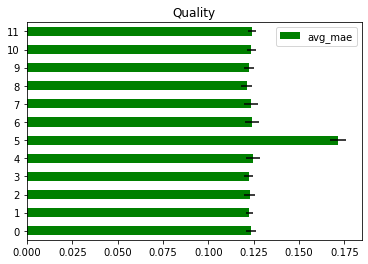

In [18]:
df_total_result_agg.plot(kind = "barh", y = "avg_mae", legend = True, xerr = "std_mae", title = "Quality", color='green')